In [6]:
from google.colab import files
uploaded = files.upload()

Saving agents.py to agents.py
Saving simulation.py to simulation.py
Saving toulouse_restaurants_that_do_delivery_31.csv to toulouse_restaurants_that_do_delivery_31.csv
Saving toulouse_restaurants_with_addresses_snapped.csv to toulouse_restaurants_with_addresses_snapped.csv
Saving utils.py to utils.py


In [7]:
!pip install ortools==9.1.9490 simpy==4.0.1 geopandas==0.10.2 osmnx==1.1.1 numpy==1.21.2 shapely==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.5 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:

In [8]:
%load_ext autoreload
%autoreload 2

import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import random
from itertools import combinations
from agents import Driver, Restaurant, Customer, Order
from simulation import Simulation

## Parameters

In [9]:
n_restaurants = 15
n_drivers = 20
n_customers = 70
max_order_limit = 3
poisson_mean_order_rate = 0.01
speed = 0.005
handover_driver_threshold = 0.05; handover_customer_threshold = 0.1
total_time = 1000
handoffs_enabled = True

/usr/local/lib/python3.9/dist-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/usr/local/lib/python3.9/dist-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.9/dist-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.9/dist-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.

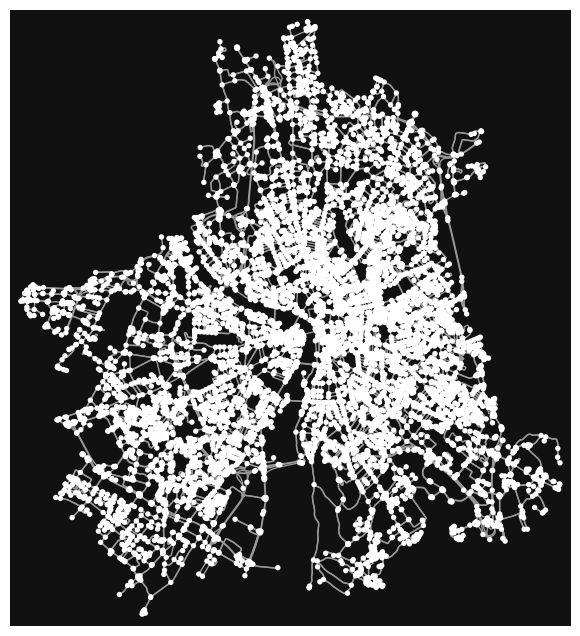

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
G = ox.graph_from_place('Toulouse, France', network_type='drive')
ox.plot_graph(G)

In [11]:
edge_set_G = [(i[0], i[1]) for i in G.edges]
nodes_G = list(G.nodes)
nodes_gdf = ox.graph_to_gdfs(G, edges=False, node_geometry=True)
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, fill_edge_geometry=True)
attr_coords_G = list(zip(nodes_gdf['y'], nodes_gdf['x']))
all_ring_coords_G =  np.array((nodes_gdf['y'], nodes_gdf['x'])).T
np.array((nodes_gdf['y'], nodes_gdf['x'])).T
#node_coords_G = dict(zip(nodes, all_ring_coords))
#node_coords_G = dict(zip([i for i in range(len(nodes_G))], all_ring_coords_G))
node_coords_G = dict(zip(nodes_G, all_ring_coords_G))

In [12]:
city_graph_G = nx.Graph()
city_graph_G.add_nodes_from(nodes_G)
city_graph_G.add_edges_from(edge_set_G)
nx.set_node_attributes(city_graph_G, dict(zip(nodes_G, attr_coords_G)), name = 'coords')

In [13]:
### If you want to upload real Toulouse restaurants for use 

#choice = "delivery_31"
choice = 'all'


if choice == "all":
    restaurants_toulouse = pd.read_csv("toulouse_restaurants_with_addresses_snapped.csv")
elif choice == "delivery_31":
    restaurants_toulouse = pd.read_csv("toulouse_restaurants_that_do_delivery_31.csv")

lats = restaurants_toulouse.latitude
lons = restaurants_toulouse.longitude

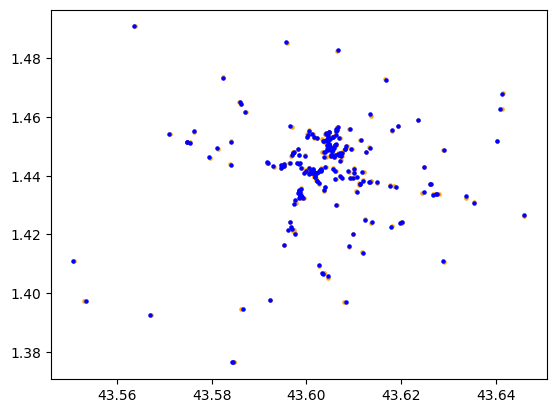

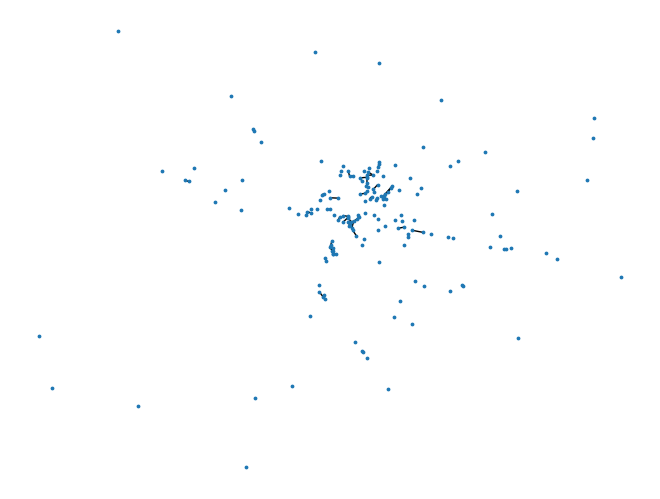

In [14]:
### To add in Toulouse Restaurant coords as nearest node:

# list of (lat, lon) tuples
tree = KDTree([(g[0], g[1]) for g in all_ring_coords_G])  # create a KDTree from the node coordinates

# assuming your latitude and longitude lists are in the variables 'lats' and 'lons'
# zip them together to get a list of (lat, lon) tuples
delivery_spots = list(zip(list(lats), list(lons)))

# find the nearest node for each coordinate within 50m
distances, indices = tree.query(delivery_spots)
#node_indices = tree.query_ball_point(delivery_spots, r=0.0009)  # 0.0005 degrees is about 50m
#node_indices = [indices for indices in node_indices if indices]  # filter out empty sublists
#node_indices = [i[0] for i in node_indices]

for j in indices:
    plt.scatter(nodes_gdf.iloc[j, 0], nodes_gdf.iloc[j, 1], color="orange", s=5)

for k in delivery_spots:
    plt.scatter(k[0], k[1], color="blue", s=5)

plt.show()

subgraph = city_graph_G.subgraph(list(nodes_gdf.iloc[list(indices)].index))
subgraph_copy = subgraph.copy()
self_loops = [(u, v) for u, v in subgraph_copy.edges() if u == v]
subgraph_copy.remove_edges_from(self_loops)
subgraph_copy.graph["crs"] = '4326'
pos = nx.get_node_attributes(subgraph_copy, 'coords')
nx.draw(subgraph_copy, pos=pos, with_labels=False, node_size=3)
plt.show()

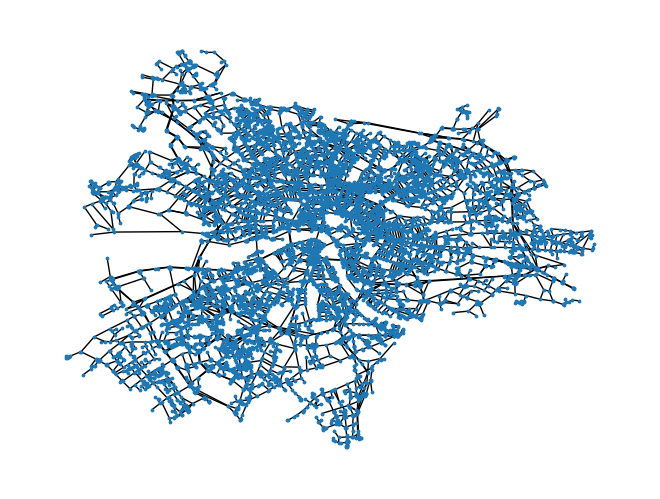

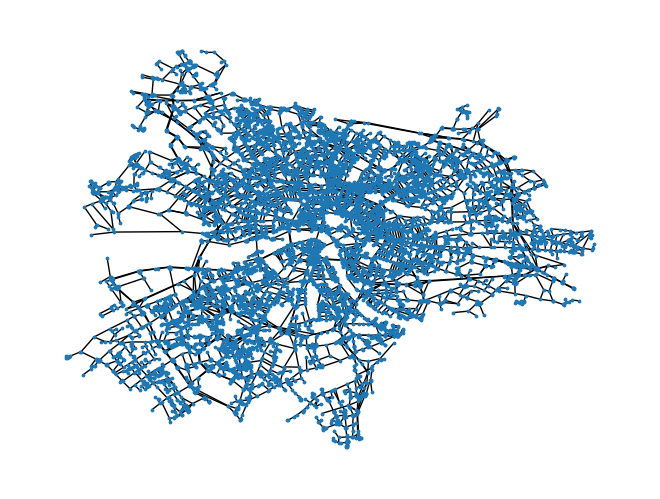

In [15]:
### If you want random points instead

subnodes = nx.ego_graph(G, 625236, radius=100).nodes
subgraph = city_graph_G.subgraph(subnodes)
subgraph_copy = subgraph.copy()
self_loops = [(u, v) for u, v in subgraph_copy.edges() if u == v]
subgraph_copy.remove_edges_from(self_loops)
subgraph_copy.graph["crs"] = '4326'
pos = nx.get_node_attributes(subgraph_copy, 'coords')
nx.draw(subgraph_copy, pos=pos, with_labels=False, node_size=3)
plt.show()
subnodes = nx.ego_graph(G, 625236, radius=100).nodes
subgraph = city_graph_G.subgraph(subnodes)
subgraph_copy = subgraph.copy()
self_loops = [(u, v) for u, v in subgraph_copy.edges() if u == v]
subgraph_copy.remove_edges_from(self_loops)
subgraph = subgraph_copy
subgraph_copy.graph["crs"] = '4326'
pos = nx.get_node_attributes(subgraph_copy, 'coords')
nx.draw(subgraph_copy, pos=pos, with_labels=False, node_size=3)
plt.show()

[2214856420, 2214844338, 6537027049, 6537027061, 245523571, 245523572, 5839542106, 252795634, 6919929842, 6919929841, 287674523, 287674468, 2222492069, 203830121, 5015842023, 5015826980, 234304005, 234301719, 2908955163, 2908955257, 166022775, 166020983, 250671472, 250671425, 250665035, 1787005063, 1926068235, 332756252, 246530998, 246530997, 348173836, 348173829, 250880171, 250880170, 2011156037, 2011156032, 2071692977, 2071588713, 240695501, 240695504, 5533916634, 269331758, 166612445, 166602467, 387263497, 386914840, 343669401, 343669400, 878506442, 239816754, 3751078125, 250958781, 2274959387, 174744378, 6390191040, 6390191035, 243450753, 243450752, 251310926, 249689976, 243850858, 243850857, 1235185871, 1227257780, 8653318500, 8653318499, 271157096, 191955049, 344221816, 9235978491, 250598083, 250598080, 2457119067, 1239206402, 360019357, 360019361, 344770429, 344770469, 239816742, 239816748, 6718809898, 6718809897, 2386804683, 60966435, 5906947081, 2010602303, 2866900491, 2544703

<ipython-input-16-cc05ef8667de>:72: UserWarning: The label '_child7' of <matplotlib.lines.Line2D object at 0x7fe79dbbaca0> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_handles, loc='lower left')


Text(0.5, 1.0, 'Randomized Delivery Configuration, Toulouse France')

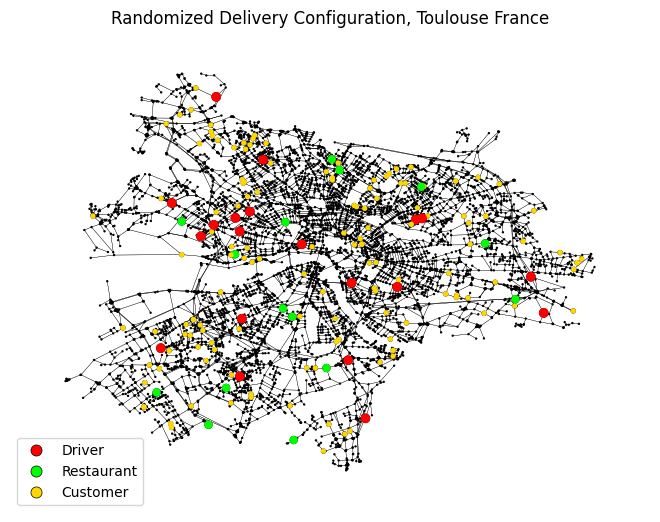

In [16]:
import random
from itertools import combinations

random.seed(0)

r_node_ids = random.sample(list(subgraph.nodes), n_restaurants)
d_node_ids = random.sample(list(subgraph.nodes), n_drivers)

d_past_node_ids = [] # needs trailing colors mechanism?
customer_nodes = [i for i in list(subgraph.nodes) if i not in (r_node_ids+d_node_ids)]

degree_one_nodes = [node for node, degree in subgraph_copy.degree() if degree == 1]

# Find connected pairs of nodes with degree 1 and get subgraph
connected_pairs = []
for node in degree_one_nodes:
    neighbors = list(subgraph_copy.neighbors(node))
    if len(neighbors) == 1 and (neighbors[0], node) not in connected_pairs:
        connected_pairs.append((node, neighbors[0]))

selected_pairs = random.sample(connected_pairs, 300)

c_node_ids = [pair for pair in selected_pairs if pair[0] not in (r_node_ids+d_node_ids) and pair[1] not in (r_node_ids+d_node_ids)][2*n_customers:3*n_customers]
c_node_ids = [item for t in c_node_ids for item in t]
#c_node_ids = list(random.sample(list(customer_nodes), n_customers))

print(c_node_ids)
r_coords = {i: list(node_coords_G[r_node_ids[i]]) for i in range(0, n_restaurants)} # should the key just be the node_id instead?
d_coords = {i: list(node_coords_G[d_node_ids[i]]) for i in range(0, n_drivers)}
c_coords = {i: list(node_coords_G[c_node_ids[i]]) for i in range(0, n_customers)}

colors = []

print(d_node_ids)
colors = []
sizes = []
for i in list(subgraph.nodes):
    if i in r_node_ids:
        colors.append('lime')
        sizes.append(25) # Set the size for restaurant nodes to be 6
    elif i in d_node_ids:
        colors.append('red')
        sizes.append(35) # Set the size for driver nodes to be 3
    elif i in d_past_node_ids:
        colors.append('red')
        sizes.append(0.5)
    elif i in c_node_ids:
        colors.append('gold')
        sizes.append(8) # Set the size for customer nodes to be 4
    else:
        colors.append('none')
        sizes.append(0.5) # Set the size for non-categorized nodes to be 1

# Draw the graph with the specified node positions, colors, and sizes
#nx.draw(subgraph, pos=nx.get_node_attributes(subgraph_copy, 'coords'), node_size=sizes, node_color=colors)


colored_nodes = [i for i in list(subgraph.nodes) if i in r_node_ids or i in d_node_ids or i in c_node_ids]
black_nodes = [i for i in list(subgraph.nodes) if i not in colored_nodes]
node_order = colored_nodes + black_nodes

cs = ['red', 'lime', 'gold', 'black']
labels = ['Driver', 'Restaurant', 'Customer', '']
color_labels = {cs[i]: labels[i] for i in range(len(cs))}

# Draw the graph with the specified node order
nx.draw(subgraph, pos=nx.get_node_attributes(subgraph, 'coords'), width=0.2, node_size=sizes, node_color="black", nodelist=node_order)

nx.draw(subgraph, pos=nx.get_node_attributes(subgraph, 'coords'), width=0.2, node_size=sizes, node_color=colors, nodelist=node_order)
#plt.scatter(lats, lons, color='green', s=25, zorder=999)
legend_handles = [plt.plot([], [], marker='o', color=color, markersize=8, ls="", mec='black', mew=0.5, label=label)[0] for color, label in color_labels.items()]
plt.legend(handles=legend_handles, loc='lower left')

plt.title("Randomized Delivery Configuration, Toulouse France")
#nx.draw(subgraph, pos = nx.get_node_attributes(subgraph_copy, 'coords'), node_size = 3, node_color = colors)


In [17]:
try:
    del city_graph
except:
    pass

In [18]:
import random
import numpy as np
import csv

# ... (your existing imports, classes and functions) ...

def write_data_to_csv(time, drivers, orders, file_name="simulation_data.csv"):
    with open(file_name, mode="a", newline="") as file:
        writer = csv.writer(file)

        # Write the header only once, when the file is empty
        if file.tell() == 0:
            writer.writerow(["Timestamp", "Driver_ID", "Customer_ID", "Restaurant_ID", "Order_Number", "Driver_Orders", "Driver_Longitude", "Driver_Latitude"])

        for d_id, driver in drivers.items():
            # If there are no orders to process, just write the driver coordinates
            if len(driver.pending_orders) == 0 and len(driver.carrying_orders) == 0:
                writer.writerow([time, d_id, None, None, None, None, driver.coords[0], driver.coords[1]])
            else:
                for order_id in driver.pending_orders + driver.carrying_orders:
                    order = orders[order_id]
                    writer.writerow([time, d_id, order.customer_id, order.restaurant_id, order_id, driver.pending_orders + driver.carrying_orders, driver.coords[0], driver.coords[1]])


In [19]:
# Write the header before starting the loop
with open("output.csv", "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    header = ["Timestamp", "Driver_ID", "Customer_ID", "Restaurant_ID", "Order_Number", "Driver_Orders", "Driver_Longitude", "Driver_Latitude"]
    csv_writer.writerow(header)


In [20]:
import csv

def save_customers_to_csv(customers, file_name='customer_coordinates.csv'):
    with open(file_name, 'w', newline='') as csvfile:
        fieldnames = ['Customer_ID', 'Latitude', 'Longitude']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for c_id, customer in customers.items():
            writer.writerow({'Customer_ID': c_id, 'Latitude': customer.coords[0], 'Longitude': customer.coords[1]})

def save_restaurants_to_csv(restaurants, file_name='restaurant_coordinates.csv'):
    with open(file_name, 'w', newline='') as csvfile:
        fieldnames = ['Restaurant_ID', 'Latitude', 'Longitude']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for r_id, restaurant in restaurants.items():
            writer.writerow({'Restaurant_ID': r_id, 'Latitude': restaurant.coords[0], 'Longitude': restaurant.coords[1]})


In [21]:
r_node_map = {k:v for k, v in enumerate(r_node_ids)}
c_node_map = {k:v for k, v in enumerate(c_node_ids)}
d_node_map = {k:v for k, v in enumerate(d_node_ids)}

restaurants = {r_id: Restaurant(r_id, r_coords[r_id]) for r_id in range(0, n_restaurants)}
customers = {c_id: Customer(c_id, c_coords[c_id]) for c_id in range(0, n_customers)}
drivers = {d_id: Driver(d_id, d_coords[d_id], d_node_map, max_order_limit, speed) for d_id in range(0, n_drivers)}

agents = [restaurants, customers, drivers]
agent_node_map = [r_node_map, c_node_map, d_node_map]

sim = Simulation(subgraph, node_coords_G, *agents, *agent_node_map, speed, handover_driver_threshold, handover_customer_threshold)

# Save customer and restaurant coordinates to CSV files
save_customers_to_csv(sim.customers, 'customer_coordinates.csv')
save_restaurants_to_csv(sim.restaurants, 'restaurant_coordinates.csv')

In [4]:

max_od_id = 0
track_drivers = [[] for _ in range(n_drivers)]
np.random.seed(0)

for time in range(0, total_time):
    # Make sure we track globally where all drivers are
    sim.update_driver_location()

    #------------------- handoff check --------------------------#
    if handoffs_enabled:
        sim.check_all_handoffs(time)
    
    # At each time step re-initialize the random customer list
    c_ids = [i for i in range(0, n_customers)]
    random.shuffle(c_ids)
    
    #------------------- Order generation phase ------------------#
    for r_id, restaurant in sim.restaurants.items():
        
        # Generate orders according to PD
#        if time <= 100:
        n_orders = np.random.poisson(lam=poisson_mean_order_rate)
#             #n_orders = np.random.poisson(lam=0.1, size=1)[0]
#         else:
#             n_orders = 0
        
        # Initialize new orders & add to the order queue
        for order_id in range(max_od_id, max_od_id+n_orders):

            # Since c_list is shuffled, popping last is random
            c_id = c_ids.pop()

            sim.orders[order_id] = Order(order_id, time, r_id, c_id)
            restaurant.order_queue.append(order_id)
            
        # Only update if necessary
        max_od_id += n_orders
        
        # Find a driver to allocate order to
        for order_id in restaurant.order_queue:
            restaurant.allocate_to_driver(order_id, sim)        
    
    #------------------- Loop through each driver -------------------#
    for d_id, driver in sim.drivers.items():
        if time >= driver.pickup_release:
        
            # Update direction before moving
            driver.update_target(sim)
            driver.step(sim, time)
        
    for i in range(n_drivers):
        track_drivers[i].append(drivers[i].coords)

    #sim.view()
    sim.clock += 1

    # Write the data to the CSV file at each time step
    write_data_to_csv(time, sim.drivers, sim.orders)

NameError: ignored

## Rolling Stats

In [ ]:
order_evolution = [];
for i in range(0, max_od_id):
    order_evolution.append([sim.orders[i].order_time, sim.orders[i].pickup_time, sim.orders[i].delivery_time])
    
orders_evol_df = (pd.DataFrame(order_evolution, columns = ['ORDER_TIME','PICKUP_TIME','DELIVERY_TIME'])
                 .assign(ORDER_ID = lambda d: d.index).assign(N = 1)
                )

order_time_cumul = (orders_evol_df
                    .groupby('ORDER_TIME')['N'].sum().reset_index()
                    .rename(columns = {'ORDER_TIME':'TIME', 'N':'N_ORDERS'})
                    )

pickup_time_cumul = (orders_evol_df
                    .groupby('PICKUP_TIME')['N'].sum().reset_index()
                    .rename(columns = {'PICKUP_TIME':'TIME', 'N':'N_PICKUP'})
                    )

delivery_time_cumul = (orders_evol_df
                       .groupby('DELIVERY_TIME')['N'].sum().reset_index()
                       .rename(columns = {'DELIVERY_TIME':'TIME', 'N':'N_DELIVERY'})
                       )

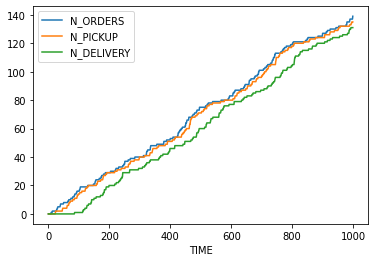

In [ ]:
(pd.DataFrame(range(0, time), columns = ['TIME'])
 .merge(order_time_cumul, how = 'outer')
 .merge(pickup_time_cumul, how = 'outer')
 .merge(delivery_time_cumul, how = 'outer')
 .fillna(0)
 .set_index('TIME').cumsum().plot()
);

<AxesSubplot:ylabel='Frequency'>

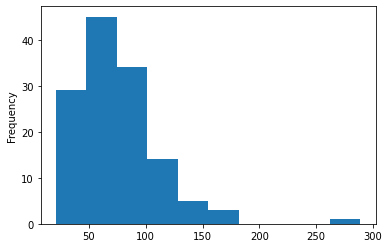

In [ ]:
(orders_evol_df
 .assign(TOTAL_DURATION = lambda d: d['DELIVERY_TIME']-d['ORDER_TIME'])
 .TOTAL_DURATION.plot.hist()
)

In [ ]:
(orders_evol_df
 .assign(TOTAL_DURATION = lambda d: d['DELIVERY_TIME']-d['ORDER_TIME'])
 .TOTAL_DURATION.dropna().mean()
)

DT    80.142857
dtype: float64

In [ ]:
for k, v in sim.orders.items():
    if v.handoff:
        print (v.handoff)

True
True
True
True
True
True
True
True
True
True


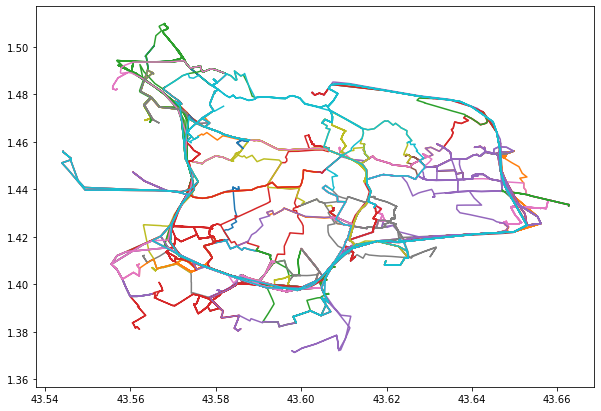

In [ ]:
plt.subplots(figsize = (10, 7))

for idx, t_d in enumerate(track_drivers):
    d = np.array(t_d)
    plt.plot(d[:, 0], d[:, 1])

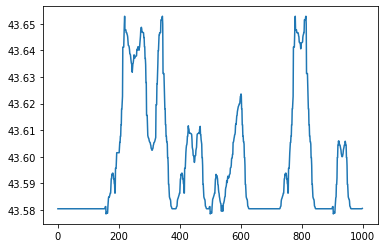

In [ ]:
t_d = track_drivers[4]
d = np.array(t_d)
plt.plot(d[:, 0])